In [3]:
import logging
import pandas as pd
import time
from pathlib import Path
from docling_core.types.doc import ImageRefMode, PictureItem, TableItem
from docling.datamodel.base_models import FigureElement, InputFormat, Table
from docling.datamodel.pipeline_options import PdfPipelineOptions
from docling.document_converter import DocumentConverter, PdfFormatOption

import torch

from docling.datamodel.pipeline_options import (
    EasyOcrOptions,
    OcrMacOptions,
    PdfPipelineOptions,
    RapidOcrOptions,
    TesseractCliOcrOptions,
    TesseractOcrOptions,
    AcceleratorDevice,
    AcceleratorOptions,
)

OCR_TYPES = {
    "easy": EasyOcrOptions,
    "mac": OcrMacOptions,
    "rapid": RapidOcrOptions,
    "tesseract": TesseractOcrOptions,
    "tesseract_cli": TesseractCliOcrOptions,
}


_log = logging.getLogger(__name__)

In [4]:
logging.basicConfig(level=logging.INFO)

input_doc_path = Path("../sample_doc.pdf")
output_dir = Path("scratch")


In [5]:
accelerator_device = AcceleratorDevice.MPS if torch.backends.mps.is_available() else AcceleratorDevice.CUDA if torch.cuda.is_available() else AcceleratorDevice.CPU

accelerator_options = AcceleratorOptions(
    num_threads=8, device=accelerator_device
)


In [8]:

IMAGE_RESOLUTION_SCALE = 2.0

# Important: For operating with page images, we must keep them, otherwise the DocumentConverter
# will destroy them for cleaning up memory.
# This is done by setting PdfPipelineOptions.images_scale, which also defines the scale of images.
# scale=1 correspond of a standard 72 DPI image
# The PdfPipelineOptions.generate_* are the selectors for the document elements which will be enriched
# with the image field
pipeline_options = PdfPipelineOptions()
pipeline_options.accelerator_options = accelerator_options
pipeline_options.images_scale = IMAGE_RESOLUTION_SCALE
pipeline_options.generate_page_images = True
pipeline_options.generate_picture_images = True
pipeline_options.do_ocr = True
pipeline_options.do_table_structure = True
pipeline_options.table_structure_options.do_cell_matching = True

ocr_options = EasyOcrOptions(force_full_page_ocr=True)
pipeline_options.ocr_options = ocr_options


doc_converter = DocumentConverter(
    format_options={
        InputFormat.PDF: PdfFormatOption(pipeline_options=pipeline_options)
    }
)

class Converter:
    def __init__(self):
        self.pipeline_options.accelerator_options = accelerator_options
        self.doc_converter = DocumentConverter(
            format_options={
                InputFormat.PDF: PdfFormatOption(pipeline_options=self.pipeline_options)
            }
        )

    def run(self, input_doc_path: Path):
        return self.doc_converter.convert(input_doc_path)

class SimpleConverter(Converter):
    def __init__(self):
        self.pipeline_options = PdfPipelineOptions()
        self.pipeline_options.do_ocr = False
        self.pipeline_options.do_table_structure = False
        super().__init__()

class TableConverter(Converter):
    def __init__(self):
        self.pipeline_options = PdfPipelineOptions()
        self.pipeline_options.do_ocr = False
        self.pipeline_options.do_table_structure = True
        self.pipeline_options.table_structure_options.do_cell_matching = True
        super().__init__()

class OCRConverter(Converter):
    def __init__(self, ocr_type: str = "easy"):
        self.pipeline_options = PdfPipelineOptions()
        self.pipeline_options.do_ocr = True
        self.pipeline_options.do_table_structure = False
        self.pipeline_options.ocr_options = OCR_TYPES[ocr_type](force_full_page_ocr=True)
        super().__init__()

class ImageConverter(Converter):
    def __init__(self, image_scale: float = IMAGE_RESOLUTION_SCALE):
        self.pipeline_options = PdfPipelineOptions()
        self.pipeline_options.images_scale = image_scale
        self.pipeline_options.generate_page_images = True
        self.pipeline_options.generate_picture_images = True
        self.pipeline_options.do_ocr = False
        self.pipeline_options.do_table_structure = False
        super().__init__()

class FullConverter(Converter):
    def __init__(
            self,
            ocr_type: str = "easy",
            image_scale: float = IMAGE_RESOLUTION_SCALE
    ):
        self.pipeline_options = PdfPipelineOptions()
        self.pipeline_options.do_ocr = True
        self.pipeline_options.do_table_structure = True
        self.pipeline_options.images_scale = image_scale
        self.pipeline_options.generate_page_images = True
        self.pipeline_options.generate_picture_images = True
        self.pipeline_options.table_structure_options.do_cell_matching = True
        self.pipeline_options.ocr_options = OCR_TYPES[ocr_type](force_full_page_ocr=True)
        super().__init__()
    

In [9]:
# set the full converter
converter = FullConverter()

start_time = time.time()

conv_res = converter.run(input_doc_path)

output_dir.mkdir(parents=True, exist_ok=True)
doc_filename = conv_res.input.file.stem

end_time = time.time() - start_time

print(f'Document converted and processedin {end_time:.2f} seconds.')

INFO:docling.document_converter:Going to convert document batch...
INFO:docling.document_converter:Initializing pipeline for StandardPdfPipeline with options hash 22049f89de3a1facc8eb2cd46c0f6b38
INFO:docling.models.factories.base_factory:Loading plugin 'docling_defaults'
INFO:docling.models.factories:Registered ocr engines: ['easyocr', 'ocrmac', 'rapidocr', 'tesserocr', 'tesseract']
INFO:docling.utils.accelerator_utils:Accelerator device: 'mps'
INFO:docling.utils.accelerator_utils:Accelerator device: 'mps'
INFO:docling.utils.accelerator_utils:Accelerator device: 'mps'
INFO:docling.models.factories.base_factory:Loading plugin 'docling_defaults'
INFO:docling.models.factories:Registered picture descriptions: ['vlm', 'api']
INFO:docling.pipeline.base_pipeline:Processing document sample_doc.pdf
INFO:docling.document_converter:Finished converting document sample_doc.pdf in 139.04 sec.


Document converted and processedin 139.05 seconds.


In [15]:
tables_elements = []
pictures_elements = []
table_data = []

# Save page images
for page_no, page in conv_res.document.pages.items():
    page_no = page.page_no
    page_image_filename = output_dir / f"{doc_filename}-{page_no}.png"
    with page_image_filename.open("wb") as fp:
        page.image.pil_image.save(fp, format="PNG")

# Save images of figures and tables
table_counter = 0
picture_counter = 0
for element, _level in conv_res.document.iterate_items():
    if isinstance(element, TableItem):
        tables_elements.append(element)
        table_df: pd.DataFrame = element.export_to_dataframe()
        # print(f"## Table {table_ix}")
        # print(table_df.to_markdown())

        table_counter += 1
        element_image_filename = (
            output_dir / f"{doc_filename}-table-{table_counter}.png"
        )
        with element_image_filename.open("wb") as fp:
            element.get_image(conv_res.document).save(fp, "PNG")
        # Save the table as csv
        element_csv_filename = output_dir / f"{doc_filename}-table-{table_counter}.csv"
        _log.info(f"Saving CSV table to {element_csv_filename}")
        table_df.to_csv(element_csv_filename)

    if isinstance(element, PictureItem):
        pictures_elements.append(element)
        picture_counter += 1
        element_image_filename = (
            output_dir / f"{doc_filename}-picture-{picture_counter}.png"
        )
        with element_image_filename.open("wb") as fp:
            element.get_image(conv_res.document).save(fp, "PNG")



    # # Save the table as html
    # element_html_filename = output_dir / f"{doc_filename}-table-{table_ix+1}.html"
    # _log.info(f"Saving HTML table to {element_html_filename}")
    # with element_html_filename.open("w") as fp:
    #     fp.write(table.export_to_html())

# # Save markdown with embedded pictures
# md_filename = output_dir / f"{doc_filename}-with-images.md"
# conv_res.document.save_as_markdown(md_filename, image_mode=ImageRefMode.EMBEDDED)

# Save markdown with externally referenced pictures
md_filename = output_dir / f"{doc_filename}-with-image-refs.md"
conv_res.document.save_as_markdown(md_filename, image_mode=ImageRefMode.REFERENCED)

# # Save HTML with externally referenced pictures
# html_filename = output_dir / f"{doc_filename}-with-image-refs.html"
# conv_res.document.save_as_html(html_filename, image_mode=ImageRefMode.REFERENCED)


INFO:__main__:Saving CSV table to scratch/sample_doc-table-1.csv
INFO:__main__:Saving CSV table to scratch/sample_doc-table-2.csv
INFO:__main__:Saving CSV table to scratch/sample_doc-table-3.csv
INFO:__main__:Saving CSV table to scratch/sample_doc-table-4.csv
INFO:__main__:Saving CSV table to scratch/sample_doc-table-5.csv
INFO:__main__:Saving CSV table to scratch/sample_doc-table-6.csv


In [16]:
tables_elements[0]

TableItem(self_ref='#/tables/0', parent=RefItem(cref='#/body'), children=[RefItem(cref='#/texts/40')], content_layer=<ContentLayer.BODY: 'body'>, label=<DocItemLabel.TABLE: 'table'>, prov=[ProvenanceItem(page_no=3, bbox=BoundingBox(l=35.360958099365234, t=734.6209335327148, r=559.2257080078125, b=515.8768920898438, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), charspan=(0, 0))], captions=[RefItem(cref='#/texts/40')], references=[], footnotes=[], image=None, data=TableData(table_cells=[TableCell(bbox=BoundingBox(l=101.604, t=112.91200000000003, r=161.849, b=121.20100000000002, coord_origin=<CoordOrigin.TOPLEFT: 'TOPLEFT'>), row_span=1, col_span=1, start_row_offset_idx=0, end_row_offset_idx=1, start_col_offset_idx=0, end_col_offset_idx=1, text='Characteristics', column_header=True, row_header=False, row_section=False), TableCell(bbox=BoundingBox(l=233.713, t=112.91200000000003, r=334.58, b=121.20100000000002, coord_origin=<CoordOrigin.TOPLEFT: 'TOPLEFT'>), row_span=1, col_span=1,

self_ref='#/pictures/0' parent=RefItem(cref='#/body') children=[RefItem(cref='#/texts/0'), RefItem(cref='#/texts/1')] content_layer=<ContentLayer.BODY: 'body'> label=<DocItemLabel.PICTURE: 'picture'> prov=[ProvenanceItem(page_no=1, bbox=BoundingBox(l=35.389442443847656, t=792.8033485412598, r=167.49331665039062, b=754.5708999633789, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), charspan=(0, 0))] captions=[] references=[] footnotes=[] image=ImageRef(mimetype='image/png', dpi=144, size=Size(width=264.0, height=77.0), uri=AnyUrl('')) annotations=[]

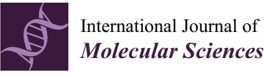

In [17]:
print(pictures_elements[0])